In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [31]:
import pathlib
import pickle
import random

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_test_split,
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, TruncatedVGG19

In [3]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

In [4]:
sites = {
    "SO2",
    # "ES-LTERA",
    # "FR-LAM",
    "FR-BIL",
    "NARYN",
}
train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(
    f"Num train {len(train_patches)}\n"
    # f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 8159
Num test 3498


In [ ]:
# Compute data mean and std for channels
train_patches.set_transform(lambda x, y: (x[:3, :, :], y[:3, :, :]))
loader = DataLoader(train_patches, batch_size=256)
channel_means = torch.zeros((3, 1, 1))
channel_std = torch.zeros((3, 1, 1))
hr_channel_means = torch.zeros((3, 1, 1))
hr_channel_std = torch.zeros((3, 1, 1))

for low_res, high_res in loader:
    channel_means += torch.mean(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    channel_std += torch.std(low_res, (0, 2, 3), keepdim=True).squeeze(0)
    hr_channel_means += torch.mean(high_res, (0, 2, 3), keepdim=True).squeeze(0)
    hr_channel_std += torch.std(high_res, (0, 2, 3), keepdim=True).squeeze(0)

channel_means /= len(loader)
channel_std /= len(loader)
hr_channel_means /= len(loader)
hr_channel_std /= len(loader)

In [ ]:
channel_means, hr_channel_means

(tensor([[[0.0480]],
 
         [[0.0763]],
 
         [[0.0792]]]),
 tensor([[[0.0477]],
 
         [[0.0758]],
 
         [[0.0793]]]))

In [ ]:
channel_std, hr_channel_std

(tensor([[[0.0262]],
 
         [[0.0334]],
 
         [[0.0517]]]),
 tensor([[[0.0260]],
 
         [[0.0332]],
 
         [[0.0517]]]))

In [5]:
# def channel_scale(x, y):
#     x = x[:3, :, :]
#     y = y[:3, :, :]
#     x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
#     x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)
#     y_channel_max = y.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
#     y_channel_min = y.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

#     x = (x - x_channel_min) / (x_channel_max - x_channel_min)
#     y = (y - y_channel_min) / (y_channel_max - y_channel_min)

#     return x, y


def channel_scale(x):
    x = x[:3, :, :]
    x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

    x = (x - x_channel_min) / (x_channel_max - x_channel_min)

    return x


# hr_channel_means = hr_channel_means.to(device)
# hr_channel_std = hr_channel_std.to(device)


def standardize(y):

    return (y - hr_channel_means.unsqueeze(0)) / hr_channel_std.unsqueeze(0)


def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    # x = (x - channel_means) / channel_std
    # y = (y - hr_channel_means) / hr_channel_std

    return x, y

In [6]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [25]:
train_loader = DataLoader(train_patches, batch_size=100)

In [29]:
(low_res, high_res) = next(train_loader.__iter__())

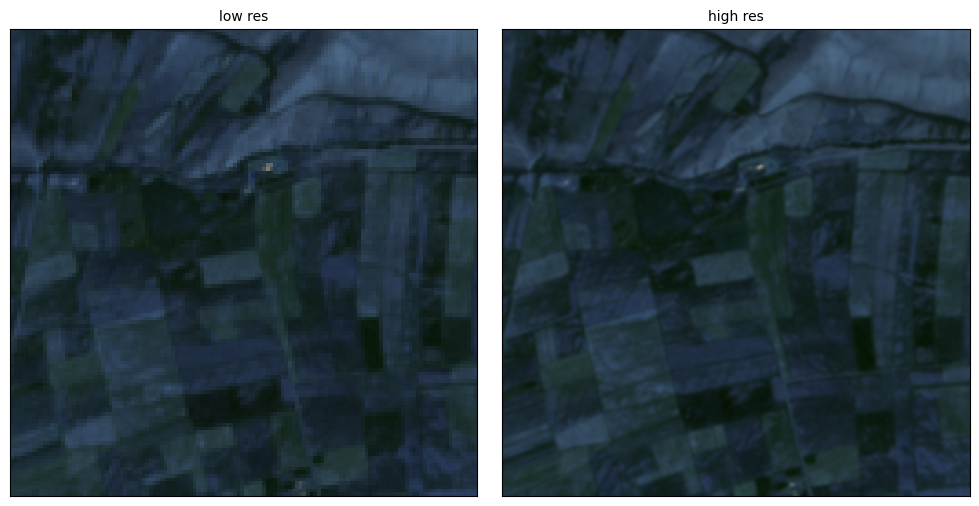

In [69]:
index = random.randint(0, len(low_res) - 1)
low_res_example = low_res[index]


high_res_example = high_res[index]


plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

In [ ]:
# For clearing GPU memory
1 / 0

In [ ]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=16,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [71]:
device

device(type='cuda')

In [72]:
model = SRResNet(scaling_factor=2, n_blocks=4)

In [73]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

In [93]:
model = model.to(device)
model = model.train()

In [75]:
vgg = TruncatedVGG19().to(device)
vgg = vgg.eval()
vgg = vgg.requires_grad_(False)

In [76]:
NUM_EPOCHS = 200

In [77]:
losses = []
epoch_losses = []

In [94]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    epoch_loss = 0.0
    epoch_vgg_loss = 0.0
    epoch_pixel_loss = 0.0
    for low_res_batch, high_res_batch in progress_bar:
        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        optimizer.zero_grad()

        # Loss and update
        out = model(low_res_batch).clamp(0, 1)
        # low_vgg = vgg(standardize(out))
        # high_vgg = vgg(high_res_batch).detach()
        # vgg_loss = criterion(low_vgg, high_vgg)
        pixel_loss = criterion(out, high_res_batch)
        loss = pixel_loss
        # loss = 10 * pixel_loss + vgg_loss
        loss.backward()
        optimizer.step()

        # Collect data
        epoch_loss += loss.item()
        # epoch_vgg_loss += vgg_loss.item()
        epoch_pixel_loss += pixel_loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix(
            epoch=epoch,
            # batch_loss=loss.item(),
            # vggl=vgg_loss.item(),
            pl=pixel_loss.item(),
        )

    epoch_loss /= len(train_loader)
    epoch_vgg_loss /= len(train_loader)
    epoch_pixel_loss /= len(train_loader)
    epoch_losses.append(epoch_loss)
    print(
        f"Epoch: {epoch} / loss: {epoch_loss:.8f} / vgg_loss: {epoch_vgg_loss:.6f} / pixel_loss: {epoch_pixel_loss:.6f}"
    )

100%|████████████████████████████████████████| 509/509 [06:51<00:00,  1.24it/s, epoch=0, pl=8.79e-5]


Epoch: 0 / loss: 0.000078 / vgg_loss: 0.000000 / pixel_loss: 0.000078


100%|████████████████████████████████████████| 509/509 [06:52<00:00,  1.23it/s, epoch=1, pl=5.75e-5]


Epoch: 1 / loss: 0.000064 / vgg_loss: 0.000000 / pixel_loss: 0.000064


100%|█████████████████████████████████████████| 509/509 [06:54<00:00,  1.23it/s, epoch=2, pl=5.9e-5]


Epoch: 2 / loss: 0.000075 / vgg_loss: 0.000000 / pixel_loss: 0.000075


100%|████████████████████████████████████████| 509/509 [06:52<00:00,  1.23it/s, epoch=3, pl=5.44e-5]


Epoch: 3 / loss: 0.000054 / vgg_loss: 0.000000 / pixel_loss: 0.000054


100%|████████████████████████████████████████| 509/509 [07:04<00:00,  1.20it/s, epoch=4, pl=3.22e-5]


Epoch: 4 / loss: 0.000048 / vgg_loss: 0.000000 / pixel_loss: 0.000048


100%|████████████████████████████████████████| 509/509 [06:55<00:00,  1.23it/s, epoch=5, pl=4.21e-5]


Epoch: 5 / loss: 0.000062 / vgg_loss: 0.000000 / pixel_loss: 0.000062


100%|████████████████████████████████████████| 509/509 [07:01<00:00,  1.21it/s, epoch=6, pl=3.11e-5]


Epoch: 6 / loss: 0.000051 / vgg_loss: 0.000000 / pixel_loss: 0.000051


100%|█████████████████████████████████████████| 509/509 [07:10<00:00,  1.18it/s, epoch=7, pl=5.3e-5]


Epoch: 7 / loss: 0.000136 / vgg_loss: 0.000000 / pixel_loss: 0.000136


100%|████████████████████████████████████████| 509/509 [07:19<00:00,  1.16it/s, epoch=8, pl=4.52e-5]


Epoch: 8 / loss: 0.000053 / vgg_loss: 0.000000 / pixel_loss: 0.000053


100%|████████████████████████████████████████| 509/509 [06:58<00:00,  1.22it/s, epoch=9, pl=3.97e-5]


Epoch: 9 / loss: 0.000046 / vgg_loss: 0.000000 / pixel_loss: 0.000046


100%|███████████████████████████████████████| 509/509 [07:47<00:00,  1.09it/s, epoch=10, pl=5.43e-5]


Epoch: 10 / loss: 0.000054 / vgg_loss: 0.000000 / pixel_loss: 0.000054


100%|███████████████████████████████████████| 509/509 [07:21<00:00,  1.15it/s, epoch=11, pl=4.47e-5]


Epoch: 11 / loss: 0.000046 / vgg_loss: 0.000000 / pixel_loss: 0.000046


100%|███████████████████████████████████████| 509/509 [07:35<00:00,  1.12it/s, epoch=12, pl=6.47e-5]


Epoch: 12 / loss: 0.000113 / vgg_loss: 0.000000 / pixel_loss: 0.000113


100%|███████████████████████████████████████| 509/509 [07:36<00:00,  1.12it/s, epoch=13, pl=5.45e-5]


Epoch: 13 / loss: 0.000068 / vgg_loss: 0.000000 / pixel_loss: 0.000068


100%|███████████████████████████████████████| 509/509 [07:35<00:00,  1.12it/s, epoch=14, pl=5.88e-5]


Epoch: 14 / loss: 0.000050 / vgg_loss: 0.000000 / pixel_loss: 0.000050


100%|████████████████████████████████████████| 509/509 [07:19<00:00,  1.16it/s, epoch=15, pl=2.8e-5]


Epoch: 15 / loss: 0.000045 / vgg_loss: 0.000000 / pixel_loss: 0.000045


100%|███████████████████████████████████████| 509/509 [07:17<00:00,  1.16it/s, epoch=16, pl=3.21e-5]


Epoch: 16 / loss: 0.000042 / vgg_loss: 0.000000 / pixel_loss: 0.000042


100%|███████████████████████████████████████| 509/509 [07:04<00:00,  1.20it/s, epoch=17, pl=4.94e-5]


Epoch: 17 / loss: 0.000042 / vgg_loss: 0.000000 / pixel_loss: 0.000042


  1%|▌                                        | 7/509 [00:05<07:03,  1.18it/s, epoch=18, pl=3.33e-5]


KeyboardInterrupt: 

In [95]:
len(epoch_losses)

20

In [96]:
epoch_losses[-5:]

[6.751187556122603e-05,
 5.026670771869163e-05,
 4.479108965628156e-05,
 4.191078306077421e-05,
 4.1501883398556225e-05]

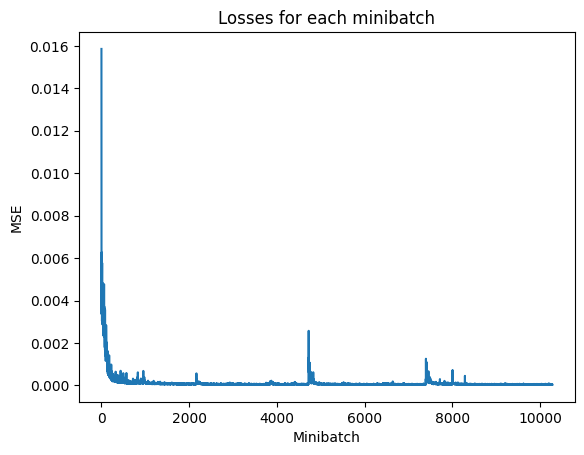

In [97]:
plt.plot(losses)
plt.title("Losses for each minibatch")
plt.xlabel("Minibatch")
plt.ylabel("MSE")
plt.show()

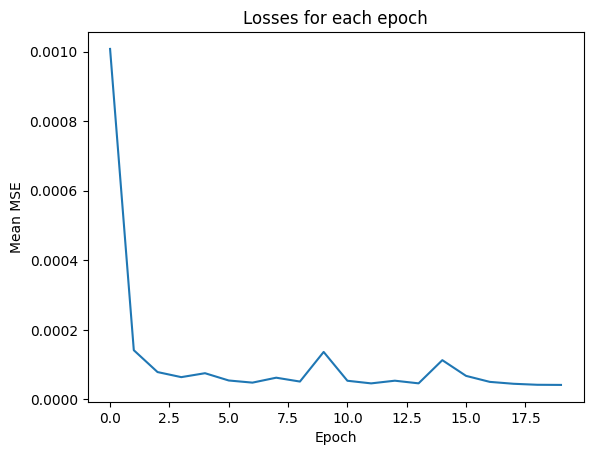

In [98]:
plt.plot(epoch_losses)
plt.title("Losses for each epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean MSE")
plt.show()

In [99]:
experiment = {
    "epoch_losses": epoch_losses,
    "batch_losses": losses,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}

In [100]:
save_file = RESULTS_DIR / "abcdiversesites20epochs.pkl"

In [101]:
torch.save(experiment, save_file)

In [43]:
loaded_experiment = torch.load(save_file, map_location=device)

In [48]:
# model = SRResNet(scaling_factor=2, n_blocks=4).to(device)
# model.load_state_dict((loaded_experiment["model_state"]))
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
# optimizer.load_state_dict(loaded_experiment["optimizer_state"])
# epoch_losses = loaded_experiment["epoch_losses"]
# batch_losses = loaded_experiment["batch_losses"]

In [102]:
model = model.to("cpu")

In [103]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

In [104]:
channel_std = 1
channel_means = 0

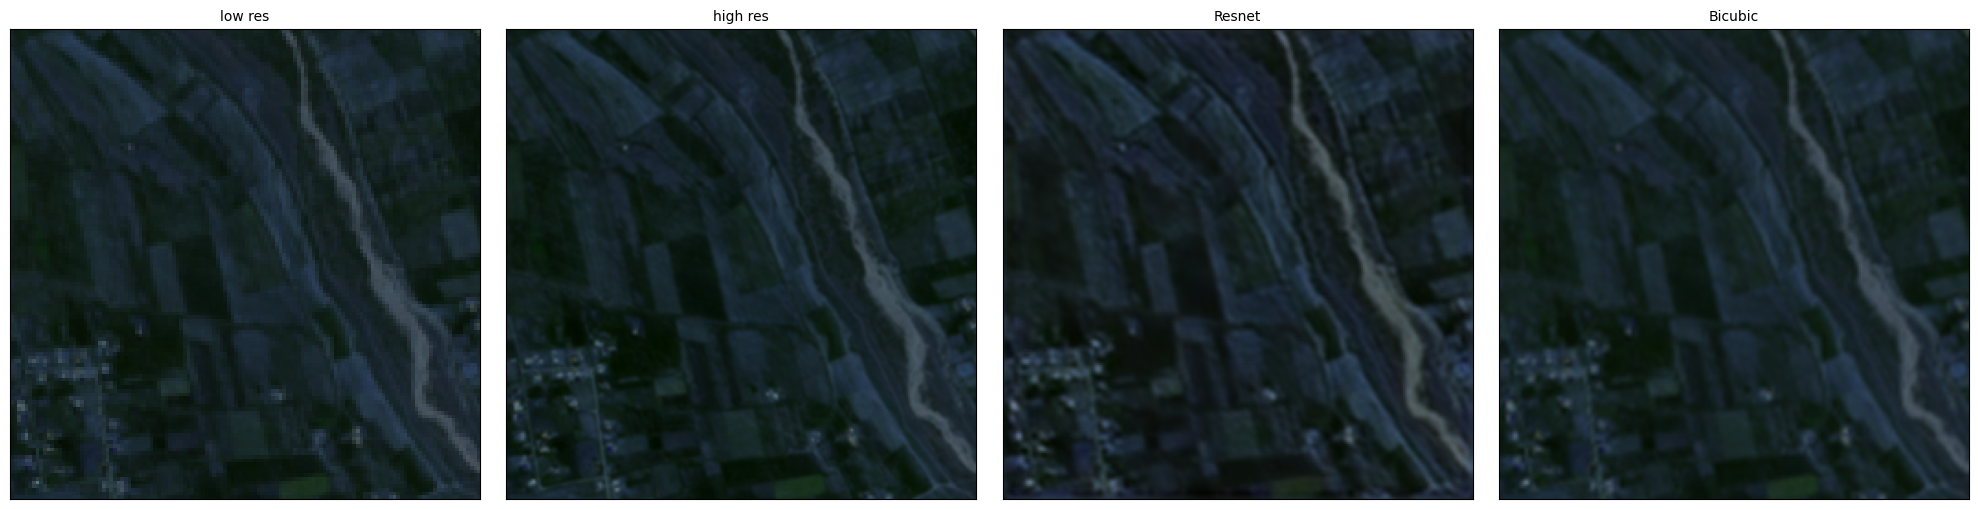

In [116]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    (low_res_example.unsqueeze(0) * channel_std + channel_means),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example * channel_std + channel_means, 2).permute(
            1, 2, 0
        ),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [117]:
loader = DataLoader(test_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

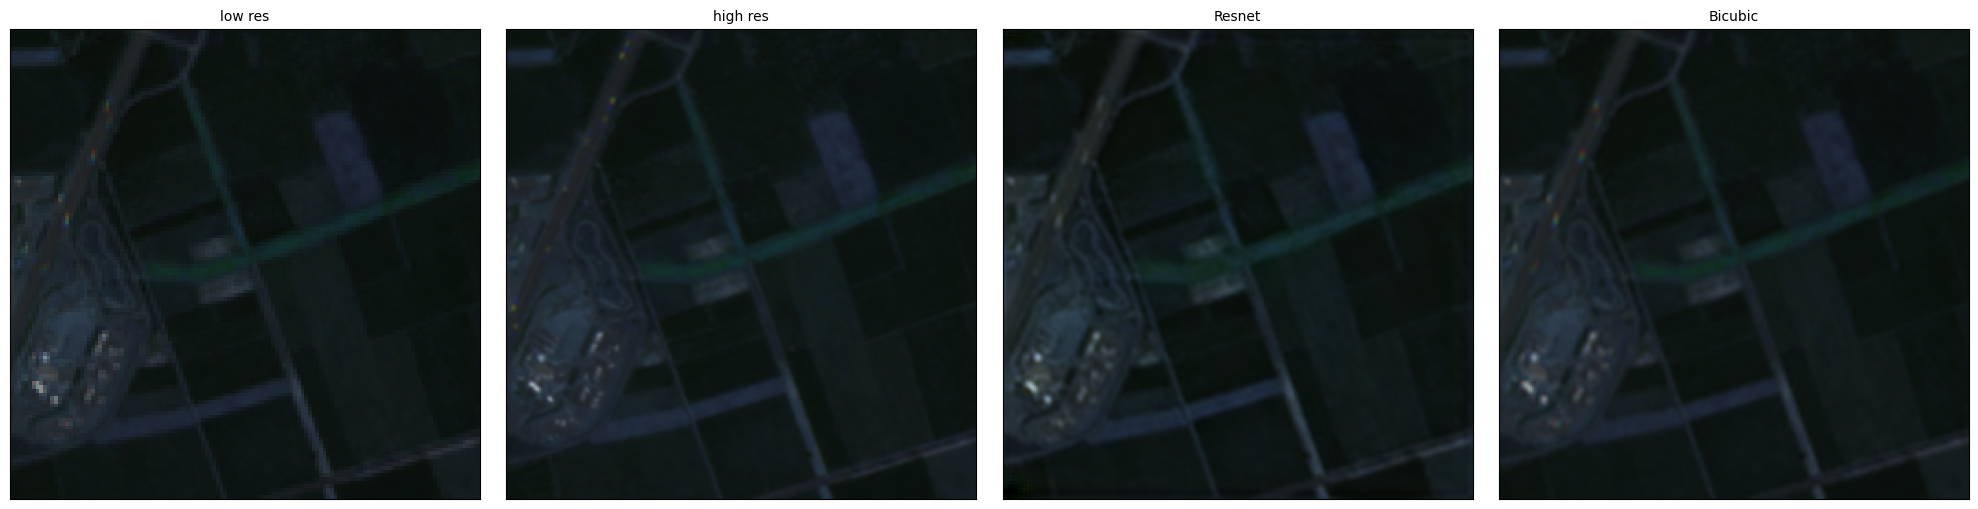

In [130]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "Resnet", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [35]:
low_res_example.max(), high_res_example.max()

(tensor(0.3325), tensor(0.3174))

In [131]:
from super_resolution.src.testing import compute_metrics

In [132]:
# 256 is largest I can handle on cpu
metric_loader = DataLoader(test_patches, batch_size=min(len(test_patches), 256))

In [133]:
metrics = compute_metrics(lambda x: model(x).clamp(0, 1), metric_loader)

100%|███████████████████████████████████████████████████████████████| 14/14 [07:53<00:00, 33.79s/it]


In [134]:
metrics

Metrics(mse=4.131700500563186e-05, psnr=43.84416716439383, ssim=0.9842713049479893)

In [135]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256)), metric_loader
)

100%|███████████████████████████████████████████████████████████████| 14/14 [03:43<00:00, 15.94s/it]


In [136]:
bicubic_metrics

Metrics(mse=5.080291625095664e-05, psnr=42.9508969443185, ssim=0.9769959960665021)